In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import random

In [2]:
with open(r'D:\study\thesis\project\HBDM-main\data\datasets\ppi\ppi_index.pkl', 'rb') as f:
    value_to_index_mapping = pickle.load(f)
len(value_to_index_mapping)

18767

In [3]:
local_stringdb = 'D:/study/thesis/project/HBDM-main/data/nn_data/stringdb/'
# load local STRING database and names
df = pd.read_csv(local_stringdb+'9606.protein.info.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
df['preferred_name'] = df['preferred_name'].str.upper()
stringId2name = df.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = df.set_index('preferred_name')['#string_protein_id'].to_dict()
df = pd.read_csv(local_stringdb+'9606.protein.aliases.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'alias']).drop_duplicates(['alias'], keep='first')
df['alias'] = df['alias'].str.upper()
aliases2stringId = df.set_index('alias')['#string_protein_id'].to_dict()


network = pd.read_csv(local_stringdb+'9606.protein.physical.links.detailed.v12.0.txt', sep=' ', header=0).convert_dtypes().replace(0, float('nan'))

network = network[['protein1','protein2','combined_score']]

In [5]:
# Define the reversed bin edges and labels
bins = [149, 199, 299, 399, 499, 599, 699, 799, 899, 999]
# labels = [9, 8, 7, 6, 5, 4, 3, 2, 1]
labels = [1,2,3,4,5,6,7,8,9]

# Use pd.cut to categorize the data into levels
network['weight'] = pd.cut(network['combined_score'], bins=bins, labels=labels, include_lowest=True)



In [6]:
network.head(3)

,protein1,protein2,combined_score,weight
0,9606.ENSP00000000233,9606.ENSP00000257770,311,3
1,9606.ENSP00000000233,9606.ENSP00000226004,161,1
2,9606.ENSP00000000233,9606.ENSP00000434442,499,4


In [7]:
network['protein1'] = network['protein1'].str.replace('9606.ENSP', '')
network['protein2'] = network['protein2'].str.replace('9606.ENSP', '')
node_array = np.array(network[['protein1','protein2']].to_numpy(), dtype=int)
mapped_arr = np.vectorize(value_to_index_mapping.get)(node_array)
mapped_arr = mapped_arr.T
mapped_arr.shape
network['node1'] = mapped_arr[0]
network['node2'] = mapped_arr[1]

In [8]:
network.head(3)

,protein1,protein2,combined_score,weight,node1,node2
0,00000000233,00000257770,311,3,0,1914
1,00000000233,00000226004,161,1,0,776
2,00000000233,00000434442,499,4,0,15878


In [10]:
G = nx.Graph()
for index, row in network.iterrows():
    G.add_edge(row['node1'], row['node2'], weight=row['weight'])

In [15]:
G.degree[0]

123

In [16]:
G.degree(weight='weight')[0]

326

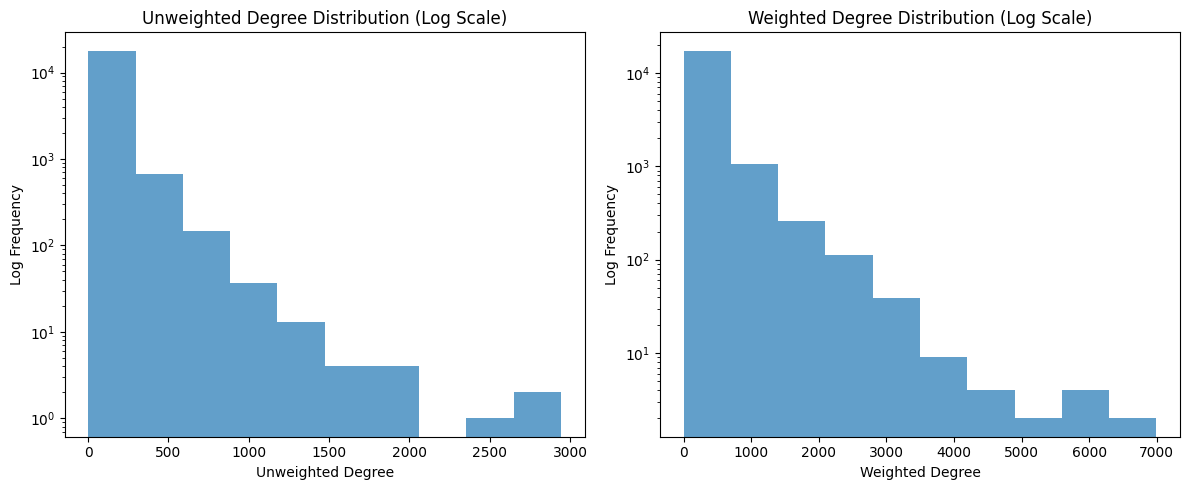

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Get the weighted degrees
weighted_degrees = dict(G.degree)

# Calculate the weighted degree distribution
counts, bins = np.histogram(list(weighted_degrees.values()), bins=10)

# Set the y-axis to a logarithmic scale
ax1.set_yscale('log')

# Customize the plot labels and title for the first subplot
ax1.set_title("Unweighted Degree Distribution (Log Scale)")
ax1.set_xlabel("Unweighted Degree")
ax1.set_ylabel("Log Frequency")

# Plot the histogram in the first subplot
ax1.bar(bins[:-1], counts, width=np.diff(bins), align='edge', alpha=0.7)

# Get the weighted degrees
weighted_degrees = dict(G.degree(weight='weight'))

# Calculate the weighted degree distribution
counts, bins = np.histogram(list(weighted_degrees.values()), bins=10)

# Set the y-axis to a logarithmic scale
ax2.set_yscale('log')

# Customize the plot labels and title for the second subplot
ax2.set_title("Weighted Degree Distribution (Log Scale)")
ax2.set_xlabel("Weighted Degree")
ax2.set_ylabel("Log Frequency")

# Plot the histogram in the second subplot
ax2.bar(bins[:-1], counts, width=np.diff(bins), align='edge', alpha=0.7)

# Adjust spacing between subplots
plt.tight_layout()

plt.show()


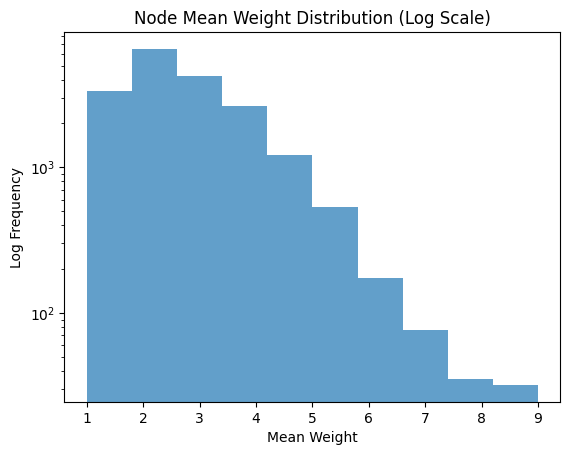

In [20]:
# Calculate the mean weight for each node
mean_weights = {}
for node in G.nodes():
    neighbors = list(G.neighbors(node))  # Convert the neighbors to a list
    if neighbors:
        total_weight = sum(G[node][neighbor]['weight'] for neighbor in neighbors)
        mean_weight = total_weight / len(neighbors)
        mean_weights[node] = mean_weight
    else:
        mean_weights[node] = 0  # Set to 0 if the node has no neighbors

# Create a histogram of the mean weights with a logarithmic y-axis scale
plt.hist(list(mean_weights.values()), bins=10, alpha=0.7)
plt.yscale('log')  # Set the y-axis to a logarithmic scale
plt.title("Node Mean Weight Distribution (Log Scale)")
plt.xlabel("Mean Weight")
plt.ylabel("Log Frequency")
plt.show()

# Test

### complexs

In [95]:
with open(r'D:\study\thesis\project\HBDM-main\data\complexes\complexes.pkl', 'rb') as f:
    complexs = pickle.load(f)
protein_names = list(aliases2stringId.keys())
protein_names.extend(list(name2stringId.keys()))

def convert_stringId(alias):
    try:
        stringId = name2stringId[alias]
    except:
        #print(alias, 'can\'t be converted by name2stringId! Now trying aliases2stringId.')
        try:
            stringId = aliases2stringId[alias]
        except:
            #print(alias, 'can\'t be converted by aliases2stringId! Now return None.')
            stringId = None
    #print(alias, stringId)
    return stringId

humans = set(value_to_index_mapping.keys())

complexs_id = dict()

for complex_name in complexs:
    # folder_path = 'D:/study/thesis/project/HBDM-main/ppi_results/test_results/'+complex_name
    # os.mkdir(folder_path)
    group_node = []
    for gene in complexs[complex_name]:
        if gene in protein_names:
            stringid = convert_stringId(gene)
            stringid = int(stringid[9:])
            if stringid in humans:
                node = value_to_index_mapping[stringid]
                group_node.append(node)
    if len(set(group_node)) != 1:
        complexs_id[complex_name] = group_node



In [96]:
for i in complexs:
    if len(complexs[i]) == 1:
        print(i)

In [97]:
col1 = []
precision_col = []
coverage_col = []
for complex_name in complexs_id:
    points = complexs_id[complex_name]
    col1.append(complex_name)
    # for top in [100,50,300]:
    for top in [50]:
        precision = []
        coverage = []
        for start_gene in points:
            test_nodes = list(set(points)-set([start_gene]))
            true_pre = []
            subdf = network[network['node1']==start_gene]
            ranked = subdf.sort_values(by='weight')
            predicted=ranked[:top]['node2'].tolist()
            for i in predicted:
                if i in test_nodes:
                    true_pre.append(i)
            precision.append(len(true_pre)/len(predicted))
            coverage.append(len(set(true_pre))/len(test_nodes))
        # print('top-',top,'\t',complex_name,' precision: ', sum(precision)/len(precision))
        # print(complex_name,' coverage: ', sum(coverage)/len(coverage))
        precision_col.append(sum(precision)/len(precision))
        coverage_col.append(sum(coverage)/len(coverage))

In [98]:
name = 'sp_10level_top50'
result = pd.DataFrame({'complex': col1, 'precision_50':precision_col,'coverage_50':coverage_col})
results_name = name +'.csv'
result.to_csv('D:/study/thesis/project/HBDM-main/ppi_results/test_results/complexes/'+results_name,index=False)

### disease

In [100]:

# # Create an empty graph
# G = nx.Graph()

# # Iterate over the DataFrame rows and add edges with weights to the graph
# for index, row in network.iterrows():
#     G.add_edge(row['node1'], row['node2'], weight=row['weight'])
# len(G.edges)

In [101]:
# disease_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\disease\Coronary artery disease.tsv',sep='\t')
# names = set(aliases2stringId.keys())
# humans = set(value_to_index_mapping.keys())

# group_node = []
# for gene in disease_df['Gene']:
#     if gene in names:
#         stringid = aliases2stringId[gene]
#         stringid = int(stringid[9:])
#         if stringid in humans:
#             node = value_to_index_mapping[stringid]
#             group_node.append(node)

In [102]:
# results = []
# for start in group_node:
#     path_weight = nx.shortest_path_length(G, source=start, weight='weight')
#     results.append(path_weight)

In [103]:

# from sklearn.model_selection import KFold


# for k in [5,10,50]:
#     k+=1
#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     for train_index, test_index in kf.split(group_node):
#         train_nodes = [group_node[i] for i in train_index]
#         test_nodes = [group_node[i] for i in test_index]
#         precision = []
#         coverage = []
#         for start in train_nodes:
#             position = points.index(start)
#             sorted_items = sorted(results[position].items(), key=lambda item: item[1])
#             sorted_keys = [item[0] for item in sorted_items]
#             true_pre = []
            
#             k_neiboger = sorted_keys[:k]
#             for nei in k_neiboger:
#                 if nei in test_nodes:
#                     true_pre.append(nei)
#             precision.append(len(true_pre)/len(df))
#             coverage.append(len(set(true_pre))/len(test_nodes))
#     print('k',k-1,'precision: ', sum(precision)/len(precision))
#     print('k',k-1,'coverage: ', sum(coverage)/len(coverage))

In [104]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# for train_index, test_index in kf.split(group_node):
#     train_nodes = [group_node[i] for i in train_index]
#     test_nodes = [group_node[i] for i in test_index]
#     true_pre = []
#     precision = []
#     coverage = []
#     subdf = df[(df['start'].isin(train_nodes))&(df['end'].isin(train_nodes))]
#     for path in subdf['path'].tolist():
#         for gene in path:
#             if gene in test_nodes:
#                 true_pre.append(gene)
#     precision.append(len(true_pre)/len(df))
#     coverage.append(len(set(true_pre))/len(test_nodes))
# print('precision: ', sum(precision)/len(precision))
# print('coverage: ', sum(coverage)/len(coverage))

In [105]:
# test_nodes = [974, 5874, 17542, 3309, 1271, 13189, 7607, 5512, 18282, 18543]
# train_nodes = list(set(group_node)-set(test_nodes))
# true_pre = []
# precision = []
# coverage = []
# subdf = df[(df['start'].isin(train_nodes))&(df['end'].isin(train_nodes))]
# for path in subdf['path'].tolist():
#     for gene in path:
#         if gene in test_nodes:
#             true_pre.append(gene)

# print('precision: ', len(true_pre)/len(df))
# print('coverage: ', len(set(true_pre))/len(test_nodes))